In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from skimage import exposure
from skimage.filters import threshold_otsu
from skimage.feature import hog
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [2]:
#importing the main folder and excel file
data_dir = '/content/drive/MyDrive/Eye/'
excel = pd.read_csv(data_dir+'data_information (1).csv')
#dividing it into 3 folders
cnv=excel[(excel['Class']=='CNV') & (excel['Label']=='CNV')]
normal=excel[(excel['Class']=='CNV') & (excel['Label']=='NORMAL')]
drusen = excel[(excel['Class']=='DRUSEN') & (excel['Label']=='DRUSEN')]
#making a sampled dataset which contain 300 images
cnv_subset = cnv.sample(n=400,random_state=42)
normal_subset = normal.sample(n=400,random_state=42)
drusen_subset = drusen.sample(n=400,random_state=42)
sampled_data = pd.concat([cnv_subset, normal_subset, drusen_subset], ignore_index=True)
drusen = pd.concat([normal_subset, drusen_subset], ignore_index=True)
cnv=pd.concat([cnv_subset, normal_subset], ignore_index=True)
both=pd.concat([cnv_subset,drusen_subset], ignore_index=True)

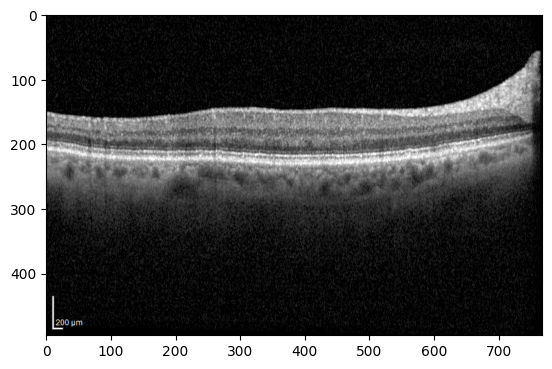

In [3]:
import cv2
images=[]
for i in both['Directory']:
  img = cv2.imread(data_dir+i)
  images.append(img)
plt.imshow(img, cmap='gray')

# **vis**

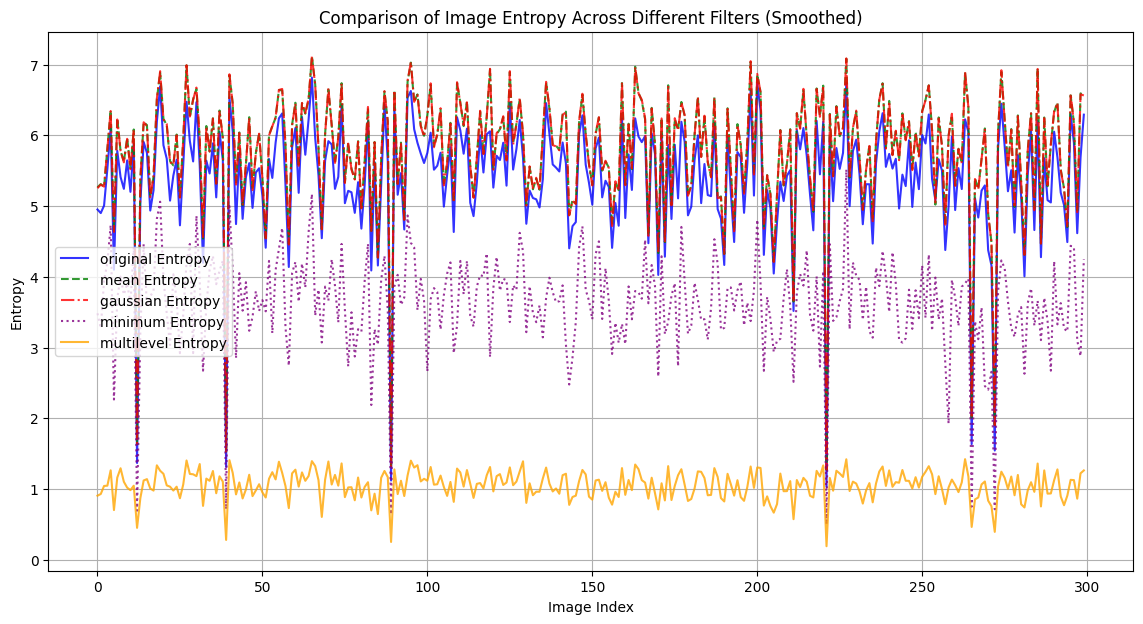

In [8]:
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import shannon_entropy

# Set your base directory
data_dir = '/content/drive/MyDrive/Eye/'

# Load the dataset
excel_path = os.path.join(data_dir, 'data_information (1).csv')
excel = pd.read_csv(excel_path)

# Define image categories and sample them
categories = {
    'cnv': excel[(excel['Class']=='CNV') & (excel['Label']=='CNV')],
    'normal': excel[(excel['Class']=='CNV') & (excel['Label']=='NORMAL')],
    'drusen': excel[(excel['Class']=='DRUSEN') & (excel['Label']=='DRUSEN')]
}

# Create a sampled dataset which contains 400 images from each category
sampled_data = pd.concat([df.sample(n=100, random_state=42) for df in categories.values()], ignore_index=True)

# Directory for saving filtered images
filtered_dir = '/content/drive/MyDrive/FilteredImages/'

# Ensure directory exists
if not os.path.exists(filtered_dir):
    os.makedirs(filtered_dir)

def apply_filters_and_calculate_metrics(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return None

    # Apply filters
    mean_img = cv2.blur(img, (3, 3))
    gaussian_img = cv2.GaussianBlur(img, (3, 3), 0)
    minimum_img = cv2.erode(img, np.ones((3, 3), np.uint8))

    # Apply multilevel thresholding using k-means clustering
    Z = img.reshape((-1, 1))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    k = 3
    _, label, center = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    multilevel_img = res.reshape((img.shape))

    # Calculate entropy for each image type
    metrics = {
        'original': shannon_entropy(img),
        'mean': shannon_entropy(mean_img),
        'gaussian': shannon_entropy(gaussian_img),
        'minimum': shannon_entropy(minimum_img),
        'multilevel': shannon_entropy(multilevel_img)
    }
    return metrics

# List to store metrics
metrics_list = []

# Iterate over sampled data
for _, row in sampled_data.iterrows():
    image_path = os.path.join(data_dir, row['Directory'])
    metrics = apply_filters_and_calculate_metrics(image_path)
    if metrics:
        metrics_list.append(metrics)

# Convert metrics list to DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics_list)

# Plotting
plt.figure(figsize=(14, 7))

# Define color and line style for clarity
plot_styles = {
    'original': {'color': 'blue', 'line': '-'},
    'mean': {'color': 'green', 'line': '--'},
    'gaussian': {'color': 'red', 'line': '-.'},
    'minimum': {'color': 'purple', 'line': ':'},
    'multilevel': {'color': 'orange', 'line': '-'}
}

for key, style in plot_styles.items():
    plt.plot(metrics_df.index, metrics_df[key], label=f'{key} Entropy',
             color=style['color'], linestyle=style['line'], alpha=0.8)

plt.title('Comparison of Image Entropy Across Different Filters (Smoothed)')
plt.xlabel('Image Index')
plt.ylabel('Entropy')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming metrics_df is loaded with correct entropy data
# Add or correct the loading of your dataframe here if necessary

def plot_entropy_comparison(metrics_df):
    plt.figure(figsize=(14, 7))

    # Define color and line style for clarity
    plot_styles = {
        'original': {'color': 'blue', 'line': '-'},
        'mean': {'color': 'green', 'line': '--'},
        'gaussian': {'color': 'red', 'line': '-.'},
        'minimum': {'color': 'purple', 'line': ':'},
        'multilevel': {'color': 'orange', 'line': '-'}
    }

    for key, style in plot_styles.items():
        plt.plot(metrics_df.index, metrics_df[key], label=f'{key} Entropy',
                 color=style['color'], linestyle=style['line'], alpha=0.8)

    plt.title('Comparison of Image Entropy Across Different Filters (Smoothed)')
    plt.xlabel('Image Index')
    plt.ylabel('Entropy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming metrics_df contains columns 'original', 'mean', 'gaussian', 'minimum', 'multilevel'
# Uncomment the line below and ensure metrics_df is correctly loaded
# plot_entropy_comparison(metrics_df)

In [11]:
print(metrics_df.describe())  # Get summary statistics for each column
print(metrics_df.head())

         original        mean    gaussian     minimum  multilevel
count  300.000000  300.000000  300.000000  300.000000  300.000000
mean     5.392949    5.770062    5.767623    3.623219    1.054471
std      0.834496    0.877096    0.878654    0.692597    0.200632
min      1.030338    1.270886    1.274598    0.498839    0.190275
25%      5.047448    5.371258    5.368468    3.291702    0.928401
50%      5.520628    5.944959    5.944536    3.691524    1.076434
75%      5.899850    6.307037    6.311743    4.005665    1.195260
max      6.817420    7.118527    7.116632    5.517807    1.420918
   original      mean  gaussian   minimum  multilevel
0  4.951247  5.264870  5.252410  3.483522    0.904833
1  4.900731  5.310620  5.302868  3.274644    0.928856
2  5.006888  5.270299  5.274976  3.945543    1.042161
3  5.526797  5.815701  5.811618  4.199617    1.046473
4  6.103481  6.352351  6.344462  4.729365    1.263366


In [ ]:
images=[]
for i in both['Directory']:
  img = cv2.imread(data_dir+i)
  images.append(img)
plt.imshow(img, cmap='gray')

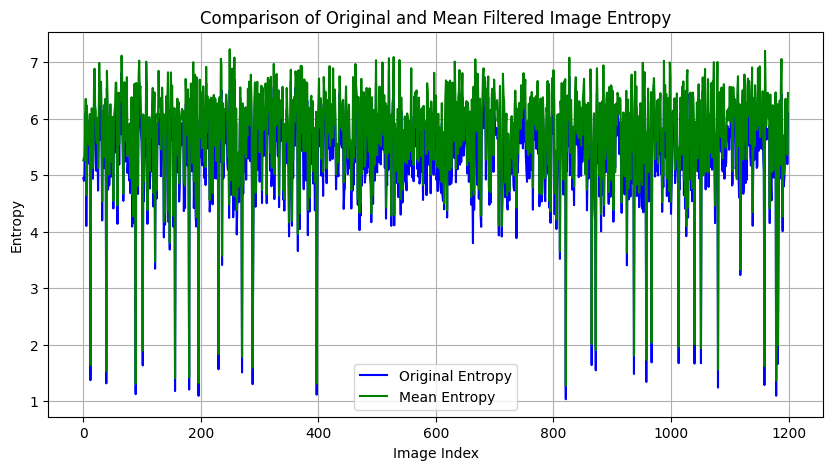

In [ ]:
import matplotlib.pyplot as plt

# Plot only original and mean to check for visibility
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['original'], label='Original Entropy', color='blue')
plt.plot(metrics_df['mean'], label='Mean Entropy', color='green')
plt.title('Comparison of Original and Mean Filtered Image Entropy')
plt.xlabel('Image Index')
plt.ylabel('Entropy')
plt.legend()
plt.grid(True)
plt.show()


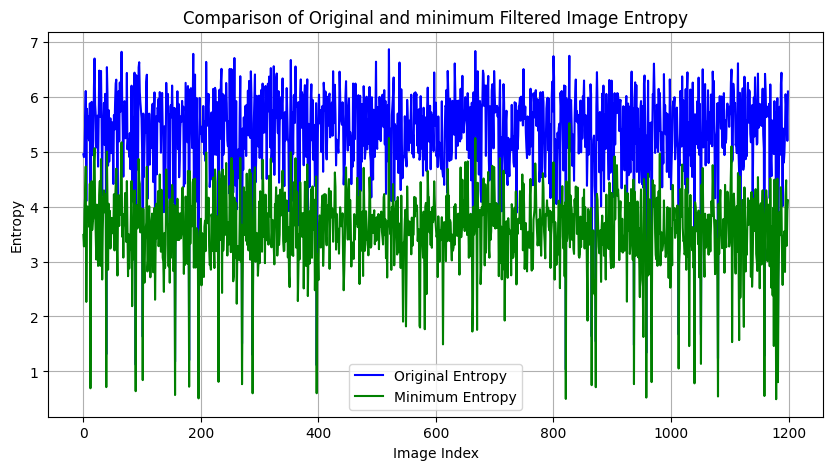

In [ ]:
# Plot only original and mean to check for visibility
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['original'], label='Original Entropy', color='blue')
plt.plot(metrics_df['minimum'], label='Minimum Entropy', color='green')
plt.title('Comparison of Original and minimum Filtered Image Entropy')
plt.xlabel('Image Index')
plt.ylabel('Entropy')
plt.legend()
plt.grid(True)
plt.show()

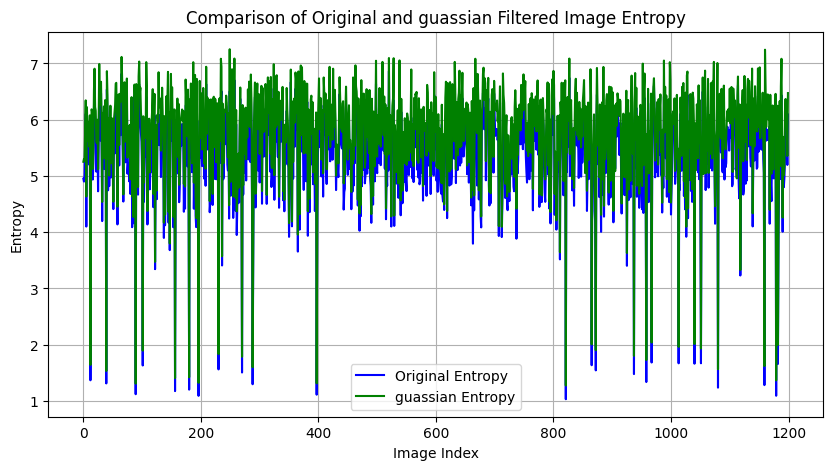

In [ ]:
# Plot only original and mean to check for visibility
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['original'], label='Original Entropy', color='blue')
plt.plot(metrics_df['gaussian'], label='guassian Entropy', color='green')
plt.title('Comparison of Original and guassian Filtered Image Entropy')
plt.xlabel('Image Index')
plt.ylabel('Entropy')
plt.legend()
plt.grid(True)
plt.show()

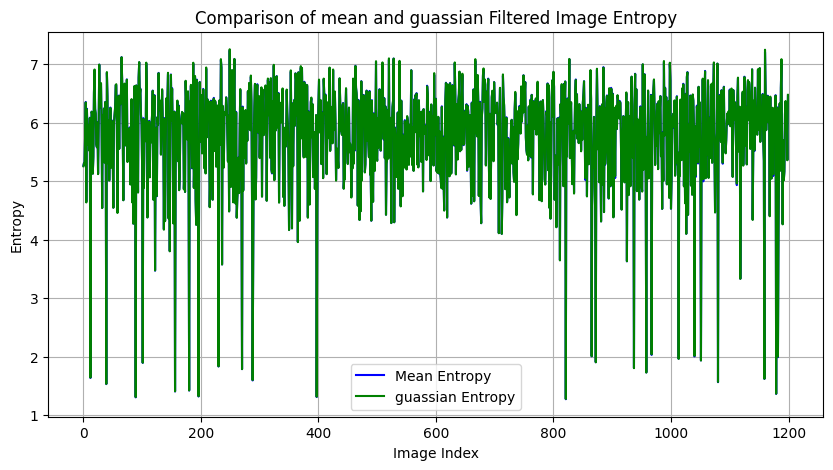

In [4]:
# Plot only original and mean to check for visibility
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['mean'], label='Mean Entropy', color='blue')
plt.plot(metrics_df['gaussian'], label='guassian Entropy', color='green')
plt.title('Comparison of mean and guassian Filtered Image Entropy')
plt.xlabel('Image Index')
plt.ylabel('Entropy')
plt.legend()
plt.grid(True)
plt.show()

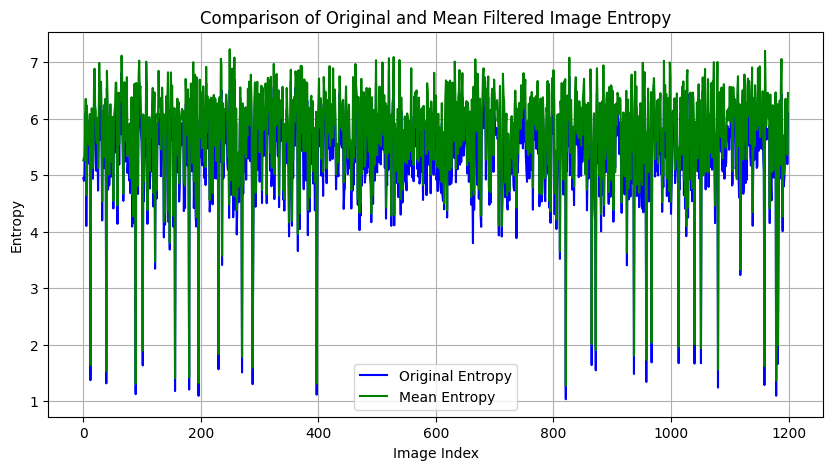

In [ ]:
import matplotlib.pyplot as plt

# Plot only original and mean to check for visibility
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['original'], label='Original Entropy', color='blue')
plt.plot(metrics_df['mean'], label='Mean Entropy', color='green')
plt.title('Comparison of Original and Mean Filtered Image Entropy')
plt.xlabel('Image Index')
plt.ylabel('Entropy')
plt.legend()
plt.grid(True)
plt.show()


# **mean** **filter**

In [ ]:
# Load images, apply mean filter, and save the filtered images to a new folder
filtered_images_dir = '/content/drive/MyDrive/Eye/Filtered/'

if not os.path.exists(filtered_images_dir):
if not os.path.exists(filtered_images_dir):
    os.makedirs(filtered_images_dir)

for index, row in both.iterrows():
    img_path = data_dir + row['Directory']
    img = cv2.imread(img_path)
    if img is not None:
        # Apply mean filter
        filtered_img = cv2.blur(img, (3, 3))  # Adjust kernel size as needed

        # Save the filtered image to the new folder
        filename = os.path.basename(img_path)
        filtered_img_path = os.path.join(filtered_images_dir, filename)
        cv2.imwrite(filtered_img_path, filtered_img)

        print(f"Filtered image saved: {filtered_img_path}")
    else:
        print(f"Error: Unable to read image '{img_path}'")


In [ ]:
filtered_images_dir = '/content/drive/MyDrive/Eye/Filtered/'
def extract_hog_features(images, do_otsu=True):
    hog_features = []
    hog_images = []
    thresholded_images = []
    for gray_image in images:
        if do_otsu:
            threshold_value = threshold_otsu(gray_image)
            threshold_image = gray_image > threshold_value
            thresholded_images.append(threshold_image)

        # Calculate HOG features
        features, hog_image = hog(threshold_image if do_otsu else gray_image,
                                  visualize=True, multichannel=False,
                                  pixels_per_cell=(8, 8), cells_per_block=(2, 2))

        # Enhance the contrast of the HOG image
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        hog_images.append(hog_image_rescaled)
        hog_features.append(features)

    return np.array(hog_features), hog_images, thresholded_images
# Load filtered images and convert to grayscale
filtered_images = []
gray_images = []
for index, row in both.iterrows():
    img_path = os.path.join(filtered_images_dir, os.path.basename(row['Directory']))
    img = cv2.imread(img_path)
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

# Extract HOG features
hog_features, hog_images, _ = extract_hog_features(gray_images)

<ipython-input-13-446a3a7c7fab>:13: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(threshold_image if do_otsu else gray_image,


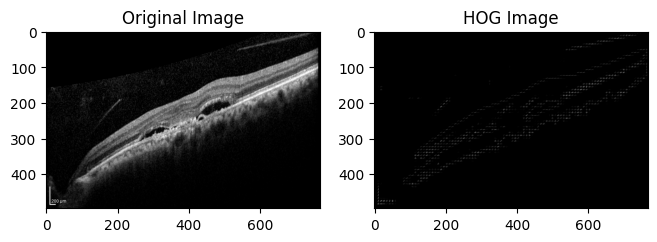

In [ ]:
# Visualize an example (adjust index as necessary)
plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.imshow(gray_images[0], cmap='gray')
plt.title('Original Image')
plt.subplot(132)
plt.imshow(hog_images[0], cmap='gray')
plt.title('HOG Image')
plt.show()

<ipython-input-23-60e0de03b083>:12: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(threshold_image if do_otsu else gray_image,


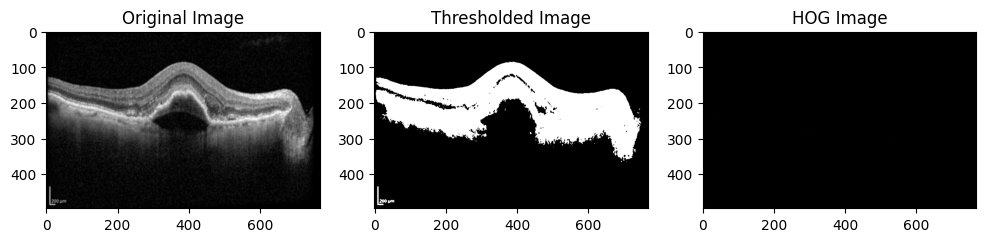

In [ ]:
hog_features = np.array(hog_features)

# Display the shape of HOG features
print("Shape of HOG features:", hog_features.shape)

Shape of HOG features: (800, 208620)


In [ ]:
# Assuming you have your labels in 'both'    DataFrame and it's properly aligned with the images
y = both['Label']

# Encode the target vector
y_encoded = y.map({'DRUSEN': 0, 'CNV': 1}).astype(int)  # Ensure you only include cases you have labels for
X = hog_features

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="linear")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.8    0.6625 0.8    0.775  0.8   ]
Mean Accuracy: 0.7675000000000001


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the Logistic Regression classifier
logistic_regression_classifier = LogisticRegression()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_lr = cross_val_score(logistic_regression_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Logistic Regression:", cv_scores_lr)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_lr = cv_scores_lr.mean()
std_dev_accuracy_lr = cv_scores_lr.std()
print("Mean Accuracy with Logistic Regression:", mean_accuracy_lr)
print("Standard Deviation of Accuracy with Logistic Regression:", std_dev_accuracy_lr)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-validation scores with Logistic Regression: [0.8     0.65    0.80625 0.7875  0.8    ]
Mean Accuracy with Logistic Regression: 0.76875
Standard Deviation of Accuracy with Logistic Regression: 0.05968668193156661


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

# Define the number of neighbors for KNN
num_neighbors = 5

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=num_neighbors)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_knn = cross_val_score(knn_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with KNN:", cv_scores_knn)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_knn = cv_scores_knn.mean()
std_dev_accuracy_knn = cv_scores_knn.std()
print("Mean Accuracy with KNN:", mean_accuracy_knn)
print("Standard Deviation of Accuracy with KNN:", std_dev_accuracy_knn)

Cross-validation scores with KNN: [0.69375 0.6375  0.725   0.6875  0.7625 ]
Mean Accuracy with KNN: 0.7012499999999999
Standard Deviation of Accuracy with KNN: 0.04153311931459037


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes classifier (Gaussian Naive Bayes)
nb_classifier = GaussianNB()

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_nb = cross_val_score(nb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Naive Bayes:", cv_scores_nb)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_nb = cv_scores_nb.mean()
std_dev_accuracy_nb = cv_scores_nb.std()
print("Mean Accuracy with Naive Bayes:", mean_accuracy_nb)
print("Standard Deviation of Accuracy with Naive Bayes:", std_dev_accuracy_nb)

Cross-validation scores with Naive Bayes: [0.59375 0.5     0.53125 0.58125 0.5625 ]
Mean Accuracy with Naive Bayes: 0.55375
Standard Deviation of Accuracy with Naive Bayes: 0.034141250709369166


In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(xgb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with XGBoost:", cv_scores)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_dev_accuracy = cv_scores.std()
print("Mean Accuracy with XGBoost:", mean_accuracy)
print("Standard Deviation of Accuracy with XGBoost:", std_dev_accuracy)

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
num_folds = 5

# Initialize the SVM classifier
svm_classifier = SVC(kernel='sigmoid')

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_dev_accuracy = cv_scores.std()
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_dev_accuracy)

Cross-validation scores: [0.8     0.6125  0.74375 0.6625  0.675  ]
Mean Accuracy: 0.6987500000000001
Standard Deviation of Accuracy: 0.06571719714047458


Gamma: 0.001, Mean Accuracy: 0.72875
Gamma: 0.01, Mean Accuracy: 0.47625
Gamma: 0.1, Mean Accuracy: 0.47000000000000003
Gamma: 1, Mean Accuracy: 0.47124999999999995
Gamma: 10, Mean Accuracy: 0.47000000000000003


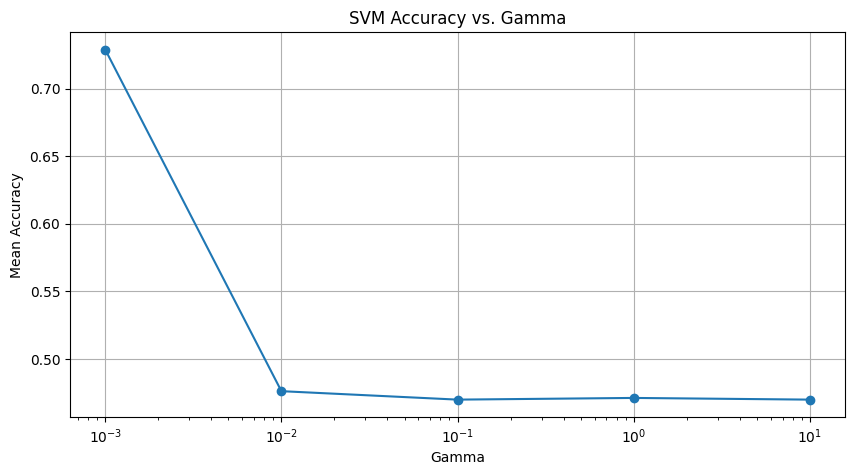

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying gamma values
gamma_values = [0.001, 0.01, 0.1, 1, 10]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each gamma
mean_accuracies = []

# Loop through each gamma value, train the SVM and calculate cross-validation scores
for gamma in gamma_values:
    svm_classifier = SVC(kernel="rbf", gamma=gamma)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Gamma: {gamma}, Mean Accuracy: {mean_accuracy}")

# You could also plot these to see how gamma affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(gamma_values, mean_accuracies, marker='o')
plt.xlabel('Gamma')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Gamma')
plt.xscale('log')  # Since gamma values vary in orders of magnitude, log scale might be more informative
plt.grid(True)
plt.show()

Degree: 1, Cross-validation scores: [0.8     0.6375  0.79375 0.7125  0.725  ]
Degree: 1, Mean Accuracy: 0.73375
Degree: 2, Cross-validation scores: [0.80625 0.66875 0.8125  0.7     0.725  ]
Degree: 2, Mean Accuracy: 0.7424999999999999
Degree: 3, Cross-validation scores: [0.7875  0.64375 0.7375  0.6875  0.65625]
Degree: 3, Mean Accuracy: 0.7025
Degree: 4, Cross-validation scores: [0.69375 0.55625 0.53125 0.61875 0.54375]
Degree: 4, Mean Accuracy: 0.5887499999999999
Degree: 5, Cross-validation scores: [0.56875 0.4875  0.48125 0.49375 0.51875]
Degree: 5, Mean Accuracy: 0.51


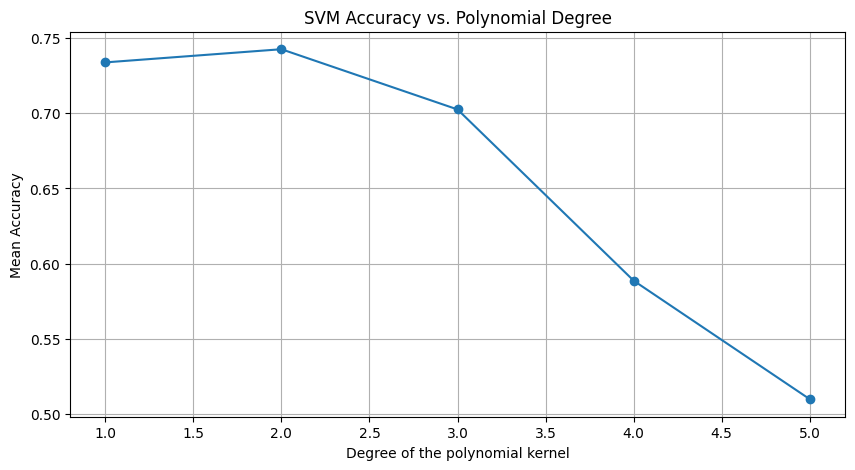

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying degrees
degree_values = [1, 2, 3, 4, 5]  # Different degrees of the polynomial to test
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each degree
mean_accuracies = []

# Loop through each degree value, train the SVM and calculate cross-validation scores
for degree in degree_values:
    svm_classifier = SVC(kernel="poly", degree=degree)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Degree: {degree}, Cross-validation scores: {cv_scores}")
    print(f"Degree: {degree}, Mean Accuracy: {mean_accuracy}")

# Optionally, you could plot these to visualize how the degree affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(degree_values, mean_accuracies, marker='o')
plt.xlabel('Degree of the polynomial kernel')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Polynomial Degree')
plt.grid(True)
plt.show()

# **guassian**

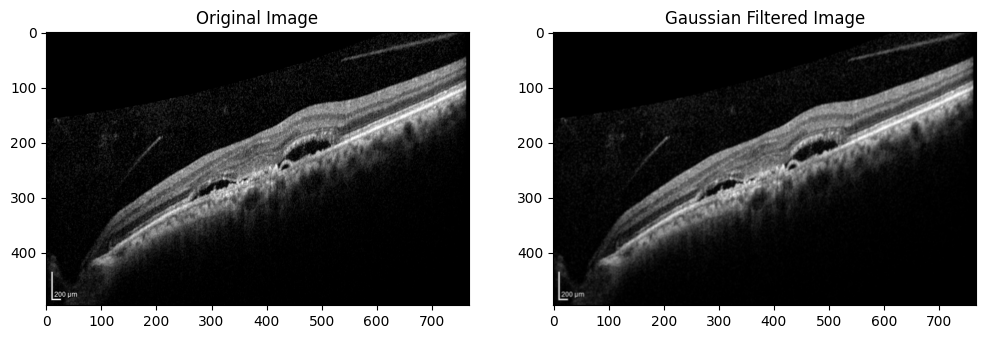

Directory /content/drive/MyDrive/GaussianFil/012_Drusen.tif could not be accessed or does not exist.


In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

# Define your base directory and new directory for the filtered images
data_dir = '/content/drive/MyDrive/Eye/'
filtered_dir = '/content/drive/MyDrive/GaussianFil'

# Create the filtered images directory if it doesn't already exist
if not os.path.exists(filtered_dir):
    os.makedirs(filtered_dir)

for idx, entry in both.iterrows():
    img_path = os.path.join(data_dir, entry['Directory'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        # Apply Gaussian Blur
        filtered_img = cv2.GaussianBlur(img, (3, 3), 0)

        # Save the filtered image
        save_path = os.path.join(filtered_dir, os.path.basename(entry['Directory']))
        cv2.imwrite(save_path, filtered_img)

        # Optionally, show the first image's original and filtered version for verification
        if idx == 0:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(img, cmap='gray')
            plt.title('Original Image')
            plt.subplot(1, 2, 2)
            plt.imshow(filtered_img, cmap='gray')
            plt.title('Gaussian Filtered Image')
            plt.show()
    else:
        print(f"Failed to load image at {img_path}")
else:
    print(f"Directory {save_path} could not be accessed or does not exist.")


In [4]:
filtered_images_dir = '/content/drive/MyDrive/GaussianFil'
def extract_hog_features(images, do_otsu=True):
    hog_features = []
    hog_images = []
    thresholded_images = []
    for gray_image in images:
        if do_otsu:
            threshold_value = threshold_otsu(gray_image)
            threshold_image = gray_image > threshold_value
            thresholded_images.append(threshold_image)

        # Calculate HOG features
        features, hog_image = hog(threshold_image if do_otsu else gray_image,
                                  visualize=True, multichannel=False,
                                  pixels_per_cell=(8, 8), cells_per_block=(2, 2))

        # Enhance the contrast of the HOG image
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        hog_images.append(hog_image_rescaled)
        hog_features.append(features)

    return np.array(hog_features), hog_images, thresholded_images
# Load filtered images and convert to grayscale
filtered_images = []
gray_images = []
for index, row in both.iterrows():
    img_path = os.path.join(filtered_images_dir, os.path.basename(row['Directory']))
    img = cv2.imread(img_path)
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

# Extract HOG features
hog_features, hog_images, _ = extract_hog_features(gray_images)

<ipython-input-4-fad6fabd3ff6>:13: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(threshold_image if do_otsu else gray_image,


In [5]:
# Assuming you have your target vector y as a pandas Series
y = both['Label']

# Encode the target vector
# Assign 0 for DRUSEN, 1 for CNV, and 2 for NORMAL
y_encoded = y.map({'DRUSEN': 0, 'CNV': 1})
X =hog_features

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="linear")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.8    0.6625 0.8    0.775  0.8   ]
Mean Accuracy: 0.7675000000000001


In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="sigmoid")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.8     0.6125  0.74375 0.6625  0.675  ]
Mean Accuracy: 0.6987500000000001


Gamma: 0.001, Mean Accuracy: 0.72875
Gamma: 0.01, Mean Accuracy: 0.47625
Gamma: 0.1, Mean Accuracy: 0.47000000000000003
Gamma: 1, Mean Accuracy: 0.47124999999999995
Gamma: 10, Mean Accuracy: 0.47000000000000003


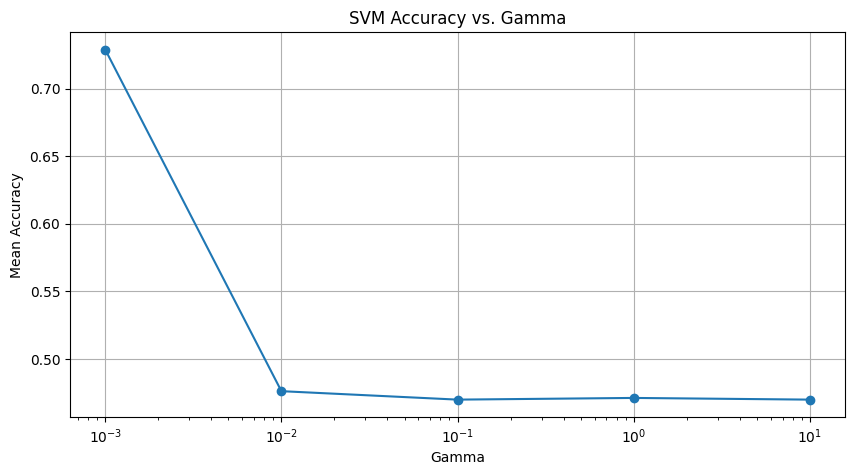

In [6]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying gamma values
gamma_values = [0.001, 0.01, 0.1, 1, 10]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each gamma
mean_accuracies = []

# Loop through each gamma value, train the SVM and calculate cross-validation scores
for gamma in gamma_values:
    svm_classifier = SVC(kernel="rbf", gamma=gamma)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Gamma: {gamma}, Mean Accuracy: {mean_accuracy}")

# You could also plot these to see how gamma affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(gamma_values, mean_accuracies, marker='o')
plt.xlabel('Gamma')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Gamma')
plt.xscale('log')  # Since gamma values vary in orders of magnitude, log scale might be more informative
plt.grid(True)
plt.show()

Degree: 1, Cross-validation scores: [0.8     0.6375  0.79375 0.7125  0.725  ]
Degree: 1, Mean Accuracy: 0.73375
Degree: 2, Cross-validation scores: [0.80625 0.66875 0.8125  0.7     0.725  ]
Degree: 2, Mean Accuracy: 0.7424999999999999
Degree: 3, Cross-validation scores: [0.7875  0.64375 0.7375  0.6875  0.65625]
Degree: 3, Mean Accuracy: 0.7025
Degree: 4, Cross-validation scores: [0.69375 0.55625 0.53125 0.61875 0.54375]
Degree: 4, Mean Accuracy: 0.5887499999999999
Degree: 5, Cross-validation scores: [0.56875 0.4875  0.48125 0.49375 0.51875]
Degree: 5, Mean Accuracy: 0.51


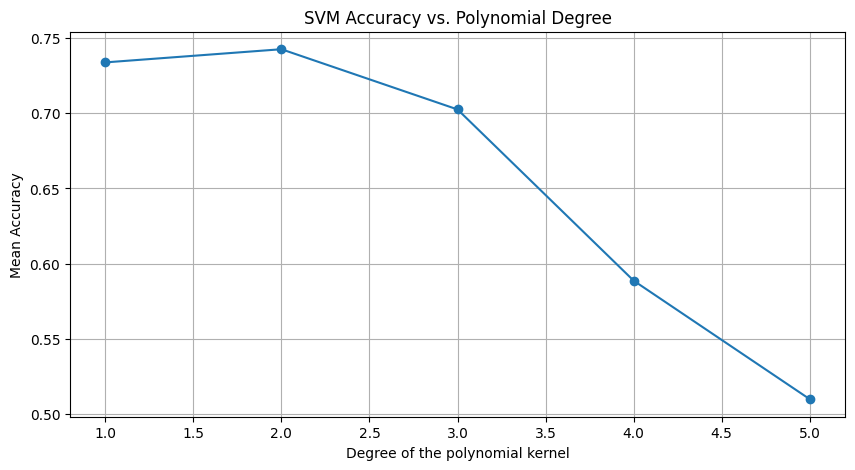

In [7]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying degrees
degree_values = [1, 2, 3, 4, 5]  # Different degrees of the polynomial to test
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each degree
mean_accuracies = []

# Loop through each degree value, train the SVM and calculate cross-validation scores
for degree in degree_values:
    svm_classifier = SVC(kernel="poly", degree=degree)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Degree: {degree}, Cross-validation scores: {cv_scores}")
    print(f"Degree: {degree}, Mean Accuracy: {mean_accuracy}")

# Optionally, you could plot these to visualize how the degree affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(degree_values, mean_accuracies, marker='o')
plt.xlabel('Degree of the polynomial kernel')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Polynomial Degree')
plt.grid(True)
plt.show()

In [6]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the Logistic Regression classifier
logistic_regression_classifier = LogisticRegression()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_lr = cross_val_score(logistic_regression_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Logistic Regression:", cv_scores_lr)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_lr = cv_scores_lr.mean()
std_dev_accuracy_lr = cv_scores_lr.std()
print("Mean Accuracy with Logistic Regression:", mean_accuracy_lr)
print("Standard Deviation of Accuracy with Logistic Regression:", std_dev_accuracy_lr)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-validation scores with Logistic Regression: [0.8     0.65    0.80625 0.7875  0.8    ]
Mean Accuracy with Logistic Regression: 0.76875
Standard Deviation of Accuracy with Logistic Regression: 0.05968668193156661


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

# Define the number of neighbors for KNN
num_neighbors = 5

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=num_neighbors)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_knn = cross_val_score(knn_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with KNN:", cv_scores_knn)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_knn = cv_scores_knn.mean()
std_dev_accuracy_knn = cv_scores_knn.std()
print("Mean Accuracy with KNN:", mean_accuracy_knn)
print("Standard Deviation of Accuracy with KNN:", std_dev_accuracy_knn)

Cross-validation scores with KNN: [0.69375 0.6375  0.725   0.6875  0.7625 ]
Mean Accuracy with KNN: 0.7012499999999999
Standard Deviation of Accuracy with KNN: 0.04153311931459037


In [8]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes classifier (Gaussian Naive Bayes)
nb_classifier = GaussianNB()

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_nb = cross_val_score(nb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Naive Bayes:", cv_scores_nb)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_nb = cv_scores_nb.mean()
std_dev_accuracy_nb = cv_scores_nb.std()
print("Mean Accuracy with Naive Bayes:", mean_accuracy_nb)
print("Standard Deviation of Accuracy with Naive Bayes:", std_dev_accuracy_nb)

Cross-validation scores with Naive Bayes: [0.59375 0.5     0.53125 0.58125 0.5625 ]
Mean Accuracy with Naive Bayes: 0.55375
Standard Deviation of Accuracy with Naive Bayes: 0.034141250709369166


In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(xgb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with XGBoost:", cv_scores)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_dev_accuracy = cv_scores.std()
print("Mean Accuracy with XGBoost:", mean_accuracy)
print("Standard Deviation of Accuracy with XGBoost:", std_dev_accuracy)

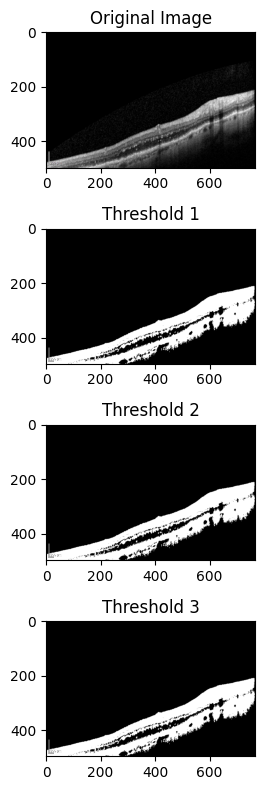

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to perform multilevel thresholding using Otsu's method
def multilevel_thresholding(image, num_thresholds):
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's thresholding to find the initial threshold
    _, initial_threshold = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Initialize the thresholds list with the initial threshold
    thresholds = [initial_threshold]

    # Calculate additional thresholds based on the initial threshold
    for _ in range(num_thresholds - 1):
        # Use the previous threshold as a mask to exclude pixels that have already been segmented
        masked_img = cv2.bitwise_and(gray_img, initial_threshold)

        # Apply Otsu's thresholding to find the next threshold
        _, threshold = cv2.threshold(masked_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Add the new threshold to the list
        thresholds.append(threshold)

        # Update the initial threshold by bitwise OR operation with the new threshold
        initial_threshold = cv2.bitwise_or(initial_threshold, threshold)

    return thresholds

# Select a random image from the dataset
idx = np.random.randint(len(cnv))
img_path = os.path.join(data_dir, cnv['Directory'].iloc[idx])
img = cv2.imread(img_path)

# Perform multilevel thresholding with 3 thresholds
num_thresholds = 3
thresholds = multilevel_thresholding(img, num_thresholds)

# Plot the original image and the thresholded images
plt.figure(figsize=(12, 8))
plt.subplot(num_thresholds + 1, 1, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

for i in range(num_thresholds):
    plt.subplot(num_thresholds + 1, 1, i + 2)
    plt.imshow(thresholds[i], cmap='gray')
    plt.title(f'Threshold {i+1}')

plt.tight_layout()
plt.show()

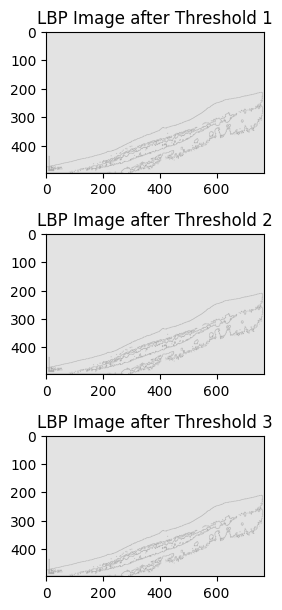

In [ ]:
from skimage.feature import local_binary_pattern

# Function to apply LBP
def apply_lbp(image):
    # Compute LBP
    radius = 1
    n_points = 8 * radius
    lbp_image = local_binary_pattern(image, n_points, radius, method='uniform')
    return lbp_image

# Apply LBP to each thresholded image
lbp_images = [apply_lbp(threshold) for threshold in thresholds]

# Plot the LBP images
plt.figure(figsize=(12, 8))
for i, lbp_image in enumerate(lbp_images):
    plt.subplot(num_thresholds + 1, 1, i + 2)
    plt.imshow(lbp_image, cmap='gray')
    plt.title(f'LBP Image after Threshold {i+1}')

plt.tight_layout()
plt.show()

# **filetring**

In [ ]:
import cv2
import numpy as np
import os
from skimage import io  # Used for reading images if cv2 fails

# Define directories
data_dir = '/content/drive/MyDrive/Eye/'
save_dir = '/content/drive/MyDrive/Multilevel'

# Ensure the save directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Function to apply multilevel thresholding using k-means clustering
def multilevel_thresholding(image_path, k=3):
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        img = io.imread(image_path, as_gray=True)  # Fallback using skimage
        if img is None:
            return None
        img = (img * 255).astype(np.uint8)  # skimage returns [0,1] float image

    # Reshape the image to a 2D array of pixels
    Z = img.reshape((-1, 1))

    # Convert to float
    Z = np.float32(Z)

    # Define criteria and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    ret, label, center = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back into uint8, and make original image shape
    center = np.uint8(center)
    res = center[label.flatten()]
    segmented_image = res.reshape((img.shape))

    return segmented_image

# Apply multilevel thresholding to each image in the sampled dataset
for idx, row in both.iterrows():
    image_path = os.path.join(data_dir, row['Directory'])
    result_image = multilevel_thresholding(image_path, k=3)  # Set k to the desired number of levels

    if result_image is not None:
        # Save the processed image
        save_path = os.path.join(save_dir, os.path.basename(row['Directory']))
        cv2.imwrite(save_path, result_image)
    else:
        print(f"Failed to load/process image: {row['Directory']}")

print("All images processed and saved to", save_dir)


All images processed and saved to /content/drive/MyDrive/Multilevel


In [4]:
filtered_images_dir ='/content/drive/MyDrive/Multilevel'
def extract_hog_features(images, do_otsu=True):
    hog_features = []
    hog_images = []
    thresholded_images = []
    for gray_image in images:
        if do_otsu:
            threshold_value = threshold_otsu(gray_image)
            threshold_image = gray_image > threshold_value
            thresholded_images.append(threshold_image)

        # Calculate HOG features
        features, hog_image = hog(threshold_image if do_otsu else gray_image,
                                  visualize=True, multichannel=False,
                                  pixels_per_cell=(8, 8), cells_per_block=(2, 2))

        # Enhance the contrast of the HOG image
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        hog_images.append(hog_image_rescaled)
        hog_features.append(features)

    return np.array(hog_features), hog_images, thresholded_images
# Load filtered images and convert to grayscale
filtered_images = []
gray_images = []
for index, row in both.iterrows():
    img_path = os.path.join(filtered_images_dir, os.path.basename(row['Directory']))
    img = cv2.imread(img_path)
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

# Extract HOG features
hog_features, hog_images, _ = extract_hog_features(gray_images)

<ipython-input-4-f178d37bae82>:13: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(threshold_image if do_otsu else gray_image,


In [5]:
# Assuming you have your target vector y as a pandas Series
y = both['Label']

# Encode the target vector
# Assign 0 for DRUSEN, 1 for CNV, and 2 for NORMAL
y_encoded = y.map({'DRUSEN': 0, 'CNV': 1})
X = hog_features

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="linear")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.8    0.6625 0.8    0.775  0.8   ]
Mean Accuracy: 0.7675000000000001


In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="sigmoid")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.8     0.6125  0.74375 0.6625  0.675  ]
Mean Accuracy: 0.6987500000000001


Degree: 1, Cross-validation scores: [0.8     0.6375  0.79375 0.7125  0.725  ]
Degree: 1, Mean Accuracy: 0.73375
Degree: 2, Cross-validation scores: [0.80625 0.66875 0.8125  0.7     0.725  ]
Degree: 2, Mean Accuracy: 0.7424999999999999
Degree: 3, Cross-validation scores: [0.7875  0.64375 0.7375  0.6875  0.65625]
Degree: 3, Mean Accuracy: 0.7025
Degree: 4, Cross-validation scores: [0.69375 0.55625 0.53125 0.61875 0.54375]
Degree: 4, Mean Accuracy: 0.5887499999999999
Degree: 5, Cross-validation scores: [0.56875 0.4875  0.48125 0.49375 0.51875]
Degree: 5, Mean Accuracy: 0.51


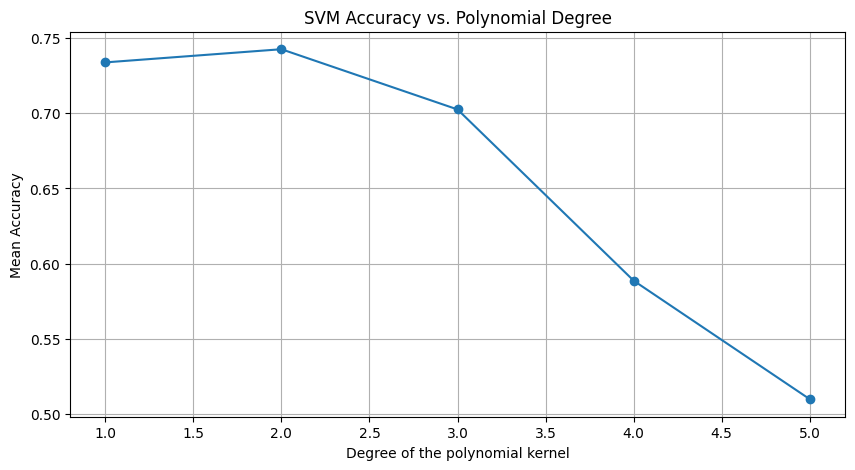

In [8]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying degrees
degree_values = [1, 2, 3, 4, 5]  # Different degrees of the polynomial to test
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each degree
mean_accuracies = []

# Loop through each degree value, train the SVM and calculate cross-validation scores
for degree in degree_values:
    svm_classifier = SVC(kernel="poly", degree=degree)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Degree: {degree}, Cross-validation scores: {cv_scores}")
    print(f"Degree: {degree}, Mean Accuracy: {mean_accuracy}")

# Optionally, you could plot these to visualize how the degree affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(degree_values, mean_accuracies, marker='o')
plt.xlabel('Degree of the polynomial kernel')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Polynomial Degree')
plt.grid(True)
plt.show()

Gamma: 0.001, Mean Accuracy: 0.72875
Gamma: 0.01, Mean Accuracy: 0.47625
Gamma: 0.1, Mean Accuracy: 0.47000000000000003
Gamma: 1, Mean Accuracy: 0.47124999999999995
Gamma: 10, Mean Accuracy: 0.47000000000000003


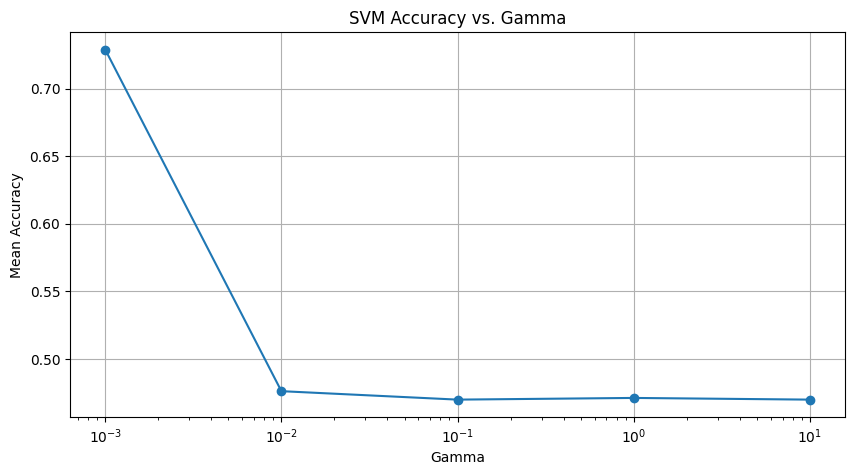

In [9]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying gamma values
gamma_values = [0.001, 0.01, 0.1, 1, 10]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each gamma
mean_accuracies = []

# Loop through each gamma value, train the SVM and calculate cross-validation scores
for gamma in gamma_values:
    svm_classifier = SVC(kernel="rbf", gamma=gamma)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Gamma: {gamma}, Mean Accuracy: {mean_accuracy}")

# You could also plot these to see how gamma affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(gamma_values, mean_accuracies, marker='o')
plt.xlabel('Gamma')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Gamma')
plt.xscale('log')  # Since gamma values vary in orders of magnitude, log scale might be more informative
plt.grid(True)
plt.show()

In [10]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the Logistic Regression classifier
logistic_regression_classifier = LogisticRegression()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_lr = cross_val_score(logistic_regression_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Logistic Regression:", cv_scores_lr)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_lr = cv_scores_lr.mean()
std_dev_accuracy_lr = cv_scores_lr.std()
print("Mean Accuracy with Logistic Regression:", mean_accuracy_lr)
print("Standard Deviation of Accuracy with Logistic Regression:", std_dev_accuracy_lr)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-validation scores with Logistic Regression: [0.8     0.65    0.80625 0.7875  0.8    ]
Mean Accuracy with Logistic Regression: 0.76875
Standard Deviation of Accuracy with Logistic Regression: 0.05968668193156661


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

# Define the number of neighbors for KNN
num_neighbors = 5

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=num_neighbors)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_knn = cross_val_score(knn_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with KNN:", cv_scores_knn)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_knn = cv_scores_knn.mean()
std_dev_accuracy_knn = cv_scores_knn.std()
print("Mean Accuracy with KNN:", mean_accuracy_knn)
print("Standard Deviation of Accuracy with KNN:", std_dev_accuracy_knn)

Cross-validation scores with KNN: [0.69375 0.6375  0.725   0.6875  0.7625 ]
Mean Accuracy with KNN: 0.7012499999999999
Standard Deviation of Accuracy with KNN: 0.04153311931459037


In [7]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes classifier (Gaussian Naive Bayes)
nb_classifier = GaussianNB()

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_nb = cross_val_score(nb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Naive Bayes:", cv_scores_nb)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_nb = cv_scores_nb.mean()
std_dev_accuracy_nb = cv_scores_nb.std()
print("Mean Accuracy with Naive Bayes:", mean_accuracy_nb)
print("Standard Deviation of Accuracy with Naive Bayes:", std_dev_accuracy_nb)

Cross-validation scores with Naive Bayes: [0.59375 0.5     0.53125 0.58125 0.5625 ]
Mean Accuracy with Naive Bayes: 0.55375
Standard Deviation of Accuracy with Naive Bayes: 0.034141250709369166


In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(xgb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with XGBoost:", cv_scores)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_dev_accuracy = cv_scores.std()
print("Mean Accuracy with XGBoost:", mean_accuracy)
print("Standard Deviation of Accuracy with XGBoost:", std_dev_accuracy)